In [272]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import _tree
import joblib
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import statistics 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

<h1>Breast Cancer</h1>

In [305]:
def load_model(path):
    return joblib.load(path)
    
loaded_model1 = load_model('C://Users/nithi/jupyter-files/Path/Collection-RFT/BreastCancer.joblib')

In [306]:
data =pd.read_csv('Random Forest Trees/Breast Cancer/Breast_Cancer.csv')

num_data=data.select_dtypes(exclude='object')
obj_data=data.select_dtypes(include='object')

la=LabelEncoder()
for i in range (0,obj_data.shape[1]):
    obj_data.iloc[:,i]=la.fit_transform(obj_data.iloc[:,i])
obj_data=obj_data.astype('int')

data=pd.concat([obj_data,num_data],axis=1)

x=data.drop('Status',axis='columns')
y=data['Status']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=21)

In [307]:
pred = loaded_model1.predict(x_test)
print(classification_report(y_test,pred))
accuracies = [accuracy_score(y_test,pred)]

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       859
           1       0.94      0.86      0.90       147

    accuracy                           0.97      1006
   macro avg       0.96      0.92      0.94      1006
weighted avg       0.97      0.97      0.97      1006



In [308]:
# Function to print the decision rules for a given tree
def print_tree_rules(tree, feature_names, tree_index, conditionalsTree):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth=0):
        nonlocal conditionalsTree
        indent = "  " * depth  # Indentation for each level
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            # Non-leaf node
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # print(f"{indent}Node {node}: (Split: {name} <= {threshold:.4f})")
            conditionals.append(f"{name} <= {threshold:.4f}")
            conditionalsTree.append(f"{name} <= {threshold:.4f}")
            # print(f"{indent}Left:")
            recurse(tree_.children_left[node], depth + 1)
            # print(f"{indent}Right:")
            recurse(tree_.children_right[node], depth + 1)
        # else:
        #     # Leaf node
        #     print(f"{indent}Leaf node {node}: (Value: {tree_.value[node]})")

    # print(f"--- Tree {tree_index} ---")  #100 dt's in forest
    recurse(0)  # Start at the root node


# Function to print decision conditionals for all trees in the forest
def print_forest_rules(forest, feature_names):
    for i, tree in enumerate(forest.estimators_):
        conditionalsTree = []
        print_tree_rules(tree, feature_names, i, conditionalsTree)
        conditionalsEachTree.append(conditionalsTree)

# Assuming you have feature names (can be saved with the model)
# If you don't have actual feature names, replace with a list of placeholder names
# feature_names = ['Feature 1', 'Feature 2', 'Feature 3', ...]  # Replace with actual feature names
feature_names = [f'Feature {i}' for i in range(loaded_model1.n_features_in_)]

conditionals = []
conditionalsEachTree = []

# Print all decision rules for the random forest
print_forest_rules(loaded_model1, feature_names)
print(len(conditionals))
print(len(conditionalsEachTree))
print(len(conditionalsEachTree[0]))

47009
100
494


In [309]:
# Function to create clusters with less than 10% difference
def create_clusters(lst, threshold):
    clusters = []  # To store the clusters
    current_cluster = [lst[0]]  # Start with the first element in a cluster

    for i in range(1, len(lst)):
        prev_num = current_cluster[0]
        current_num = lst[i]
        # Calculate the percentage difference
        if abs(current_num - prev_num) / prev_num <= threshold:
            current_cluster.append(current_num)
        else:
            clusters.append(current_cluster)  # Add the current cluster to the list
            current_cluster = [current_num]   # Start a new cluster with the current number

    # Append the last cluster
    clusters.append(current_cluster)
    
    return clusters

# # List of numbers as strings
# lst = ['1.5000', '10.0000', '10.5000', '11.0000', '11.5000', '12.0000', '12.5000', 
#        '13.0000', '13.5000', '14.0000', '14.5000', '15.0000', '15.5000', '16.0000', 
#        '16.5000', '17.0000', '17.5000', '18.0000', '18.5000', '19.0000', '19.5000', 
#        '2.0000', '2.5000', '20.0000', '20.5000', '21.0000', '21.5000', '22.0000', 
#        '22.5000', '23.0000', '23.5000', '24.0000', '24.5000', '25.0000', '25.5000', 
#        '26.0000', '26.5000', '27.0000', '27.5000', '28.5000', '29.0000', '29.5000', 
#        '3.0000', '3.5000', '30.5000', '31.0000', '31.5000', '32.5000', '33.0000', 
#        '33.5000', '34.0000', '35.0000', '35.5000', '36.0000', '36.5000', '37.0000', 
#        '37.5000', '39.0000', '4.0000', '4.5000', '5.0000', '5.5000', '6.0000', 
#        '6.5000', '7.0000', '7.5000', '8.0000', '8.5000', '9.0000', '9.5000']

# # Convert list to float
# lst = sorted([float(x) for x in lst])
    
# ## Create the clusters with a 10% threshold
# clusters = create_clusters(lst, threshold=0.1)

# ##Print the clusters
# for idx, cluster in enumerate(clusters):
#     print(f"Cluster {idx+1}: {cluster}")

In [310]:
conditionalsMap = {}
clusteredConditionalsPreMap = {}
clusteredConditionalsMap = {}
clusteredConditionalsMapMedians = {}

clusteredConditionalsPreMapTrees = []

#Count repeated conditionals in whole random forest
for i,val in enumerate(conditionals):
    if(val not in conditionalsMap):
        conditionalsMap[val]=0
    conditionalsMap[val]+=1

#whole random forest
for i,val in enumerate(conditionals):
    [featureNMapKey,featureNMapValue] = val.split(' <= ')
    if(featureNMapKey not in clusteredConditionalsPreMap):
        clusteredConditionalsPreMap[featureNMapKey] = set()
    clusteredConditionalsPreMap[featureNMapKey].add(featureNMapValue)

#for each tree
for i, lst_val in enumerate(conditionalsAllTree):
    clusteredConditionalsPreMapTree = {}
    for j,val in enumerate(lst_val):
        [featureNMapKey,featureNMapValue] = val.split(' <= ')
        if(featureNMapKey not in clusteredConditionalsPreMapTree):
            clusteredConditionalsPreMapTree[featureNMapKey] = set()
        clusteredConditionalsPreMapTree[featureNMapKey].add(featureNMapValue)
    clusteredConditionalsPreMapTrees.append(clusteredConditionalsPreMapTree)

thresholds = [0,0.1,0.6,1,99999]
ClusteredDesisionsCountLst = []
ConditionalReplacemntMapLst = []

#whole random forest
for threshold in thresholds:
    ClusteredDesisionsCount = 0
    ConditionalReplacemntMap = {}
    for cluster_key in clusteredConditionalsPreMapTree:
        cluster_value_sorted = sorted([float(x) for x in clusteredConditionalsPreMap[cluster_key]])
        clusteredConditionalsMap[cluster_key] = create_clusters(cluster_value_sorted, threshold=threshold)
        clusteredConditionalsMapMedians[cluster_key] = [statistics.median(lst) for lst in clusteredConditionalsMap[cluster_key]]
        ClusteredDesisionsCount+=len(clusteredConditionalsMapMedians[cluster_key])
    
    for cluster_key in clusteredConditionalsMap:
        for j in range(len(clusteredConditionalsMap[cluster_key])):
            replacemnt = cluster_key+"|"+str(clusteredConditionalsMapMedians[cluster_key][j])
            for k in range(len(clusteredConditionalsMap[cluster_key][j])):
                find = cluster_key+"|"+str(clusteredConditionalsMap[cluster_key][j][k])
                ConditionalReplacemntMap[find] = replacemnt
    ClusteredDesisionsCountLst.append(ClusteredDesisionsCount)
    ConditionalReplacemntMapLst.append(ConditionalReplacemntMap)

ClusteredDesisionsCountLstTree = []

#for each tree
for threshold in thresholds:
    ClusteredDesisionsCount = 0
    for i, clusteredConditionalsPreMapItem in enumerate(clusteredConditionalsPreMapTrees):
        for cluster_key in clusteredConditionalsPreMapItem:
            cluster_value_sorted = sorted([float(x) for x in clusteredConditionalsPreMapItem[cluster_key]])
            clusteredConditionalsMap[cluster_key] = create_clusters(cluster_value_sorted, threshold=threshold)
            clusteredConditionalsMapMedians[cluster_key] = [statistics.median(lst) for lst in clusteredConditionalsMap[cluster_key]]
            ClusteredDesisionsCount+=len(clusteredConditionalsMapMedians[cluster_key])
    ClusteredDesisionsCountLstTree.append(ClusteredDesisionsCount)


print(len(conditionals)," - All Nodes")
print(len(conditionalsMap)," - Similar Nodes")
for i,ClusteredDesisionsCount in enumerate(ClusteredDesisionsCountLst):
    print(ClusteredDesisionsCount, f" - {thresholds[i]*100}% of variation ")
print('___________________________________________________________')
print(len(conditionals)," - All Nodes")
for i,ClusteredDesisionsCount in enumerate(ClusteredDesisionsCountLstTree):
    print(ClusteredDesisionsCount, f" - {thresholds[i]*100}% of variation ")

47009  - All Nodes
698  - Similar Nodes
698  - 0% of variation 
169  - 10.0% of variation 
58  - 60.0% of variation 
44  - 100% of variation 
15  - 9999900% of variation 
___________________________________________________________
47009  - All Nodes
20478  - 0% of variation 
9553  - 10.0% of variation 
4509  - 60.0% of variation 
3576  - 100% of variation 
1494  - 9999900% of variation 


In [311]:
# Function to modify tree conditions based on ConditionalReplacementMap
def replace_conditions_in_tree(tree, feature_names, conditional_map):
    # Access the tree structure
    tree_structure = tree.tree_

    # Iterate through each node in the tree
    for node_index in range(tree_structure.node_count):
        feature = tree_structure.feature[node_index]
        threshold = tree_structure.threshold[node_index]

        # Skip if it's a leaf node
        if feature == -2:
            continue

        # Build the key (e.g., 'Feature 9|0.5')
        key = f"{feature_names[feature]}|{threshold}"

        # Check if the key is in the ConditionalReplacementMap
        if key in conditional_map:
            # Get the new condition
            new_condition = conditional_map[key]
            
            # Split the new condition into feature and threshold
            new_feature, new_threshold = new_condition.split('|')
            new_feature_index = feature_names.index(new_feature)

            # Update the tree with the new feature and threshold
            tree_structure.feature[node_index] = new_feature_index
            tree_structure.threshold[node_index] = float(new_threshold)

            # print(f"Node {node_index}: Replaced {key} with {new_condition}")
        ## uncomment and check if there are any conditionals not found when replacing the first time
        else:
            print("Error replacement not found",key)

# Apply the replacement for all trees in the RandomForestClassifier
def replace_conditions_in_forest(forest_model, conditional_map):
    # Get feature names based on the dataset used to train the model
    feature_names = [f'Feature {i}' for i in range(forest_model.n_features_in_)]

    # Iterate over each tree in the forest and apply condition replacement
    for i, tree in enumerate(forest_model.estimators_):
        # print(f"\nModifying tree {i+1}...")
        replace_conditions_in_tree(tree, feature_names, conditional_map)

for i,threshold in enumerate(thresholds):
    loaded_model1 = load_model('C://Users/nithi/jupyter-files/Path/Collection-RFT/BreastCancer.joblib')
    
    # Apply the function to loaded_model1
    replace_conditions_in_forest(loaded_model1, ConditionalReplacemntMapLst[i])
    
    # Optionally, re-evaluate the model after modification
    pred = loaded_model1.predict(x_test)
    print("\nModified Model Classification Report:")
    print(classification_report(y_test, pred))
    accuracy = accuracy_score(y_test, pred)
    accuracies.append(accuracy)
    print('_________________________________________________________')


Modified Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       859
           1       0.94      0.86      0.90       147

    accuracy                           0.97      1006
   macro avg       0.96      0.92      0.94      1006
weighted avg       0.97      0.97      0.97      1006

_________________________________________________________

Modified Model Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       859
           1       0.81      0.71      0.76       147

    accuracy                           0.93      1006
   macro avg       0.88      0.84      0.86      1006
weighted avg       0.93      0.93      0.93      1006

_________________________________________________________

Modified Model Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       859
    

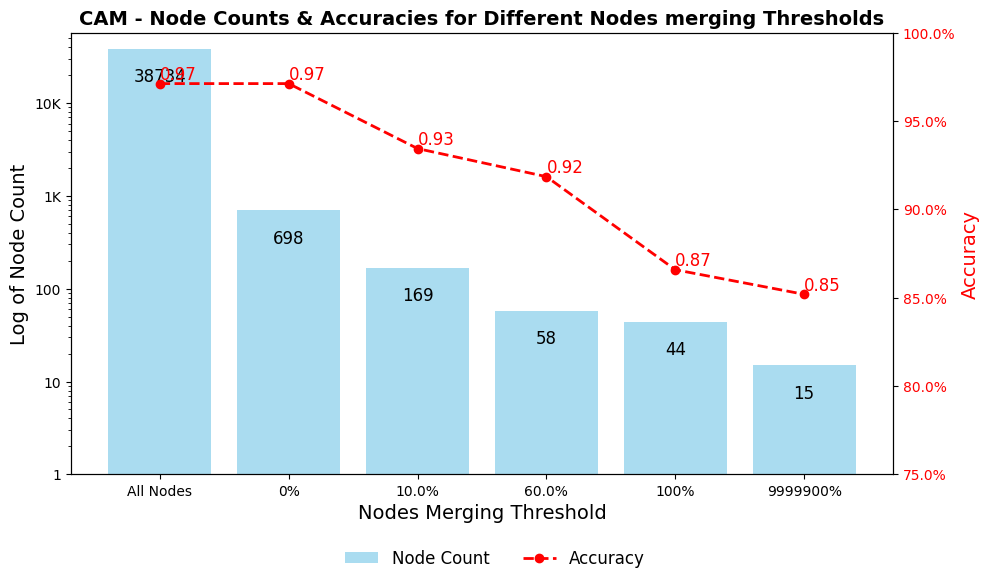

In [314]:
# Define the missing variables for plotting
# thresholds_str = ["All Nodes", "0%", "0.1%", "0.6%", "1%", "9999999%"]
# node_counts = [38734, 684, 167, 58, 44, 15]
# accuracies = [0.9075546719681908, 0.9075546719681908, 0.9005964214711729, 0.8996023856858847, 0.8687872763419483, 0.8479125248508946]

thresholds_str = ["All Nodes"]+[str(i*100)+'%' for i in thresholds]
node_counts = [AllNodes] + ClusteredDesisionsCountLst
accuracies = accuracies

# Plotting log graph with a bar chart on log scale
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart with log scale
bars = ax1.bar(thresholds_str, node_counts, color='#87CEEB', alpha=0.7, label='Node Count')

# Set y-axis to log scale for the bar chart
ax1.set_yscale('log')
ax1.set_xlabel('Nodes Merging Threshold', fontsize=14)
ax1.set_ylabel('Log of Node Count', fontsize=14)
ax1.set_title('CAM - Node Counts & Accuracies for Different Nodes merging Thresholds', fontsize=14, fontweight='bold')

# Customize ticks on the y-axis for node counts
ax1.set_yticks([1, 10, 100, 1000, 10000])
ax1.set_yticklabels(['1', '10', '100', '1K', '10K'])
# ax1.grid(True, which="both", linestyle='--', linewidth=0.5)

# Add text labels inside each bar, centered vertically and horizontally on log scale
for bar in bars:
    height = bar.get_height()
    # Add text at the middle of the bar in log scale
    ax1.text(bar.get_x() + bar.get_width() / 2, height * 0.5, f'{int(height)}',
             ha='center', va='center', fontsize=12, color='black')

# Create a second y-axis for accuracies
ax2 = ax1.twinx()

# Plot the line graph for accuracies with dotted line and markers
ax2.plot(thresholds_str, accuracies, color='red', marker='o', linestyle='--', linewidth=2, label='Accuracy')

# Add text labels for each accuracy point
for i, acc in enumerate(accuracies):
    ax2.text(thresholds_str[i], acc, f'{acc:.2f}', color='red', fontsize=12, ha='left', va='bottom')

# Set y-axis label for accuracies and limit its range
ax2.set_ylabel('Accuracy', color='red', fontsize=14)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0.75, 1)  # Set the y-axis limits for accuracy
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Display accuracy in percentage

# Move the legends outside the plot
handles1, labels1 = ax1.get_legend_handles_labels()  # Bar chart legend
handles2, labels2 = ax2.get_legend_handles_labels()  # Line chart legend
fig.legend(handles1 + handles2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, 0.05),
           ncol=2, fontsize=12, frameon=False)

# Beautify the layout with tight layout and adjust spacing for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(bottom=0.15)  # Adjust to make room for the legend

# Display the plot
plt.show()

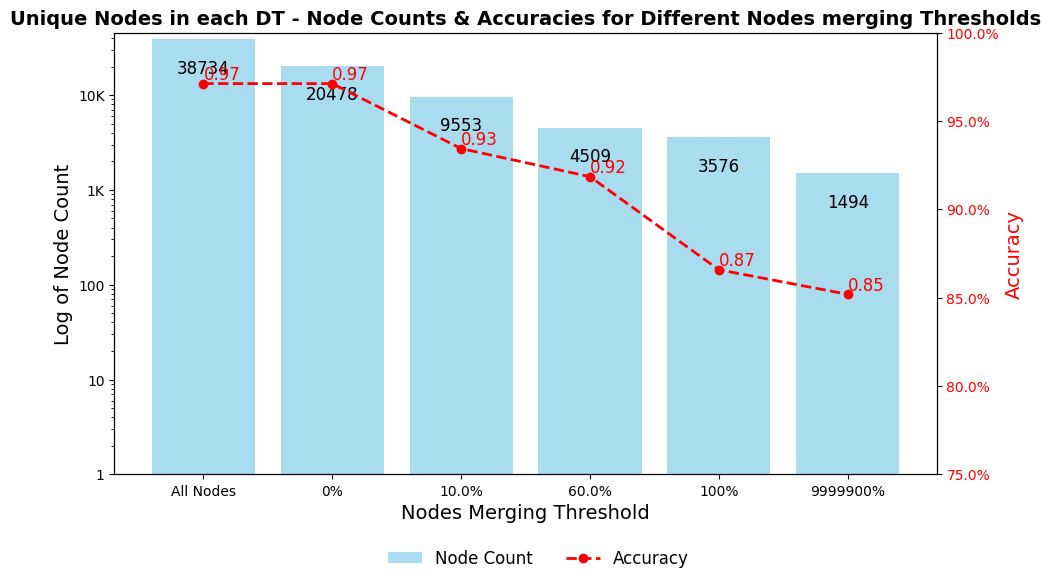

In [425]:
# Define the missing variables for plotting
# thresholds_str = ["All Nodes", "0%", "0.1%", "0.6%", "1%", "9999999%"]
# node_counts = [38734, 684, 167, 58, 44, 15]
# accuracies = [0.9075546719681908, 0.9075546719681908, 0.9005964214711729, 0.8996023856858847, 0.8687872763419483, 0.8479125248508946]

thresholds_str = ["All Nodes"]+[str(i*100)+'%' for i in thresholds]
node_counts = [AllNodes] + ClusteredDesisionsCountLstTree
accuracies = accuracies

# Plotting log graph with a bar chart on log scale
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart with log scale
bars = ax1.bar(thresholds_str, node_counts, color='#87CEEB', alpha=0.7, label='Node Count')

# Set y-axis to log scale for the bar chart
ax1.set_yscale('log')
ax1.set_xlabel('Nodes Merging Threshold', fontsize=14)
ax1.set_ylabel('Log of Node Count', fontsize=14)
ax1.set_title('Unique Nodes in each DT - Node Counts & Accuracies for Different Nodes merging Thresholds', fontsize=14, fontweight='bold')

# Customize ticks on the y-axis for node counts
ax1.set_yticks([1, 10, 100, 1000, 10000])
ax1.set_yticklabels(['1', '10', '100', '1K', '10K'])
# ax1.grid(True, which="both", linestyle='--', linewidth=0.5)

# Add text labels inside each bar, centered vertically and horizontally on log scale
for bar in bars:
    height = bar.get_height()
    # Add text at the middle of the bar in log scale
    ax1.text(bar.get_x() + bar.get_width() / 2, height * 0.5, f'{int(height)}',
             ha='center', va='center', fontsize=12, color='black')

# Create a second y-axis for accuracies
ax2 = ax1.twinx()

# Plot the line graph for accuracies with dotted line and markers
ax2.plot(thresholds_str, accuracies, color='red', marker='o', linestyle='--', linewidth=2, label='Accuracy')

# Add text labels for each accuracy point
for i, acc in enumerate(accuracies):
    ax2.text(thresholds_str[i], acc, f'{acc:.2f}', color='red', fontsize=12, ha='left', va='bottom')

# Set y-axis label for accuracies and limit its range
ax2.set_ylabel('Accuracy', color='red', fontsize=14)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0.75, 1)  # Set the y-axis limits for accuracy
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Display accuracy in percentage

# Move the legends outside the plot
handles1, labels1 = ax1.get_legend_handles_labels()  # Bar chart legend
handles2, labels2 = ax2.get_legend_handles_labels()  # Line chart legend
fig.legend(handles1 + handles2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, 0.05),
           ncol=2, fontsize=12, frameon=False)

# Beautify the layout with tight layout and adjust spacing for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(bottom=0.15)  # Adjust to make room for the legend

# Display the plot
plt.show()

<h1>Number of Memristors and FeFETS used in a Random Forest for all the decision trees</h1>
<h2>Our approch vs CAM approch</h2>

In [332]:
treeConditionalsCountLst = [len(i) for i in conditionalsAllTree]
print(len(treeConditionalsCountLst))
print(treeConditionalsCountLst)

100
[369, 337, 411, 384, 411, 394, 359, 342, 400, 379, 352, 347, 361, 382, 417, 378, 380, 368, 420, 427, 412, 414, 410, 376, 369, 425, 434, 395, 348, 383, 376, 378, 376, 342, 435, 436, 379, 415, 382, 392, 391, 413, 402, 372, 407, 417, 408, 409, 368, 396, 340, 370, 356, 409, 401, 371, 357, 408, 386, 395, 408, 369, 449, 361, 404, 395, 359, 374, 375, 399, 362, 347, 489, 377, 388, 411, 378, 369, 362, 399, 405, 388, 389, 385, 400, 381, 376, 409, 362, 383, 343, 387, 398, 399, 388, 404, 364, 366, 404, 357]


In [418]:
AllClusteredDesisionsCountEachTree=[]
for threshold in thresholds: #for each tree
    ClusteredDesisionsCountLst = []
    for i, clusteredConditionalsPreMapItem in enumerate(clusteredConditionalsPreMapTrees):
        ClusteredDesisionsCount = 0
        for cluster_key in clusteredConditionalsPreMapItem:
            cluster_value_sorted = sorted([float(x) for x in clusteredConditionalsPreMapItem[cluster_key]])
            cluster_temp = create_clusters(cluster_value_sorted, threshold=threshold)
            ClusteredDesisionsCount += len(cluster_temp)
        ClusteredDesisionsCountLst.append(ClusteredDesisionsCount)
    AllClusteredDesisionsCountEachTree.append(ClusteredDesisionsCountLst)
    
print(len(AllClusteredDesisionsCountEachTree))
print(len(AllClusteredDesisionsCountEachTree[0]))
print(AllClusteredDesisionsCountEachTree)

5
100
[[208, 183, 227, 193, 204, 222, 195, 196, 212, 200, 192, 189, 192, 204, 223, 206, 198, 204, 220, 207, 207, 218, 218, 200, 202, 216, 215, 201, 190, 204, 193, 203, 196, 190, 213, 227, 205, 215, 201, 226, 205, 209, 208, 200, 210, 200, 207, 207, 201, 215, 213, 192, 200, 216, 209, 205, 209, 202, 197, 208, 219, 198, 230, 188, 212, 209, 200, 213, 194, 211, 196, 187, 225, 195, 205, 224, 202, 193, 214, 216, 203, 214, 207, 196, 200, 198, 191, 214, 188, 203, 191, 209, 202, 207, 192, 207, 203, 203, 199, 192], [101, 88, 103, 91, 91, 98, 93, 96, 99, 95, 90, 95, 92, 97, 99, 100, 94, 95, 96, 97, 96, 98, 105, 91, 93, 102, 100, 95, 91, 92, 96, 93, 90, 91, 98, 102, 96, 93, 102, 91, 97, 100, 101, 95, 92, 91, 99, 92, 96, 98, 94, 93, 94, 96, 96, 91, 99, 94, 91, 98, 98, 100, 98, 96, 95, 101, 97, 93, 100, 91, 87, 91, 99, 92, 93, 96, 99, 90, 97, 102, 95, 96, 91, 92, 93, 98, 91, 103, 103, 97, 97, 94, 91, 97, 95, 94, 97, 95, 90, 97], [47, 43, 47, 44, 46, 46, 46, 46, 41, 46, 43, 46, 46, 44, 46, 46, 46, 43, 

<h3>Memristor count in Crossbar </h3>

In [419]:
memristors_count_trees = []
transistors_count_trees = []
for i in range(len(AllClusteredDesisionsCountEachTree)+1):
    memristors_count = []
    transistors_count = []
    for j in range(len(treeConditionalsCountLst)):
        decisionsInTree = treeConditionalsCountLst[j]
        if(i==0):
            mergedNodes = treeConditionalsCountLst[j]
            CAMMemristors = ClusteredDesisionsCountLst[i]/2*2
        else:
            mergedNodes = AllClusteredDesisionsCountEachTree[i-1][j]
            CAMMemristors = ClusteredDesisionsCountLst[i-1]/2*2

        # print(decisionsInTree,'x',mergedNodes,'=',decisionsInTree*mergedNodes)
        crossbarMemristors = decisionsInTree*mergedNodes
        
        memristors_count.append(crossbarMemristors+CAMMemristors)
        
    memristors_count_trees.append(memristors_count)

sum_memristors_count = []
for memristors_count in memristors_count_trees:
    sum_memristors_count.append(sum(memristors_count))
thresholds_str

['Threshold 1', 'Threshold 2', 'Threshold 3', 'Threshold 4']

<h3>Memristor count in CAM - 6T2M </h3>

In [420]:
# Function to count nodes from root to each leaf node in a given tree
def count_nodes_to_leaves(tree, node=0, depth=0, path_lengths=[]):
    tree_ = tree.tree_
    # Check if it's a leaf node
    if tree_.children_left[node] == _tree.TREE_LEAF and tree_.children_right[node] == _tree.TREE_LEAF:
        # Store the depth at the leaf node
        path_lengths.append(depth + 1)  # Add 1 to include the leaf node itself
    else:
        # Traverse left and right children with updated depth
        if tree_.children_left[node] != _tree.TREE_LEAF:
            count_nodes_to_leaves(tree, node=tree_.children_left[node], depth=depth + 1, path_lengths=path_lengths)
        if tree_.children_right[node] != _tree.TREE_LEAF:
            count_nodes_to_leaves(tree, node=tree_.children_right[node], depth=depth + 1, path_lengths=path_lengths)
    return path_lengths

# Function to traverse each tree in the forest and collect path lengths
def collect_leaf_path_lengths(forest):
    leaf_depths = []
    for i, tree in enumerate(forest.estimators_):
        # Initialize a list to collect path lengths for the current tree
        path_lengths = count_nodes_to_leaves(tree)
        leaf_depths.append(path_lengths)
    return leaf_depths

# Collect leaf path lengths for all trees in the random forest
CAM_Memristors = 0
leaf_depths_forest = collect_leaf_path_lengths(loaded_model1)
print(f"Total number of trees: {len(leaf_depths_forest)}")
for i, path_lengths in enumerate(leaf_depths_forest):
    # print(f"Tree {i + 1}: Number of leaf nodes = {len(path_lengths)}")
    # print(f"Tree {i + 1}: Path lengths to leaf nodes = {sum(path_lengths)}")
    CAM_Memristors += sum(path_lengths)
CAM_Memristors

Total number of trees: 100


63562300

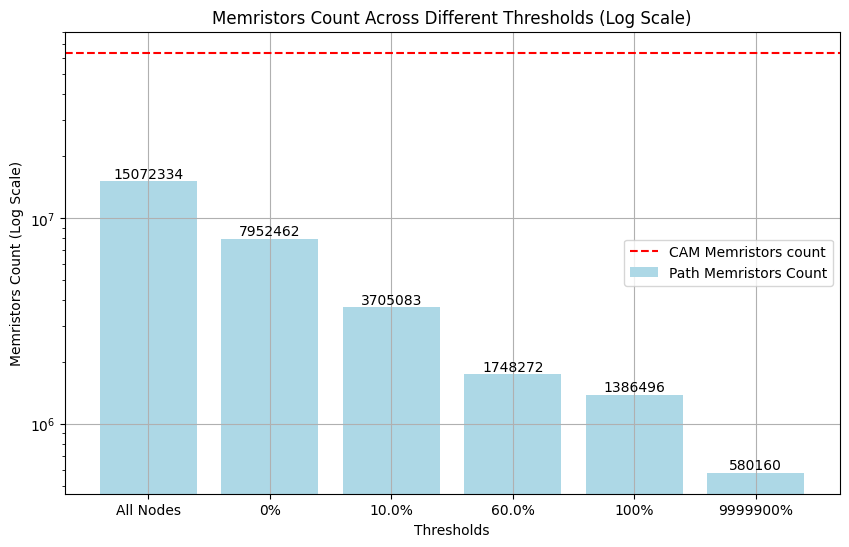

In [428]:
# Creating the bar graph with log scale on the y-axis
plt.figure(figsize=(10, 6))
plt.bar(thresholds_str, sum_memristors_count, color='lightblue', label='Path Memristors Count')
plt.axhline(y=CAM_Memristors, color='red', linestyle='--', label='CAM Memristors count')

# Set y-axis to log scale
plt.yscale('log')

# Adding text labels on each bar
for bar, count in zip(bars, sum_memristors_count):
    plt.text(bar.get_x() + bar.get_width() / 2, count, str(count).replace('.0',''),
             ha='center', va='bottom', fontsize=10)

# Adding labels and title
plt.xlabel('Thresholds')
plt.ylabel('Memristors Count (Log Scale)')
plt.title('Memristors Count Across Different Thresholds (Log Scale)')
plt.legend()
plt.grid()

# Display the plot
plt.show()

In [424]:
thresholds_str

['Threshold 1', 'Threshold 2', 'Threshold 3', 'Threshold 4']